# 100 Evaluating Classifiers

> COM6018

*Copyright &copy; 2024 Jon Barker, University of Sheffield. All rights reserved*.


## 1. Introduction

This notebook have been written to accompany the Face Verification assignment. The notebook is unlike the previous labs notebooks, in that it is not a step-by-step guide to a solution. Instead, it contains some notes and snippets of code that you may find useful. The lab uses ideas from the lecture on classifier evaluation and applies them to the assignment data.


## 2. Loading the data provided

The assignment makes use of a number of data files that you will need to download from the following location:

https://drive.google.com/drive/folders/10y3e2zKkh0lVpRZ3WC21Uu-v-EcbBSYs?usp=sharing

As described in the assignment handout, you are provided with the following files:

- `train.joblib` - the full training dataset
- `eval1.joblib` - a dataset for evaluating your model
- `baseline_model.joblib` - pre-trained kNN models, i.e., a baseline solution

If you have not downloaded these already, do so now and store them in the same directory as this notebook.

We will then load the datasets and the baseline model.

### 2.1 The training data

We will first load the training data


In [1]:
import joblib
data_train = joblib.load('train.joblib')
print(data_train.keys())
print(data_train['data'].shape)
print(data_train['target'].shape)


dict_keys(['data', 'target'])
(2200, 5828)
(2200,)


The data is stored in a 2-D array of 2200 rows of 5828 values, where each row represents the pixels in a pair of images of shape 62 rows by 47 colums. For convenience we will reshape this into a 4-D array off 2200 x 2 x 62 x 47, i.e., 2200 samples of 2 images of 62 by 47 pixels. We will then store the reshaped data back in the data_train dictionary under a key called 'images'.

In [5]:

data_train['images'] = data_train['data'].reshape((2200, 2, 62, 47))
print(data_train['images'].shape)


(2200, 2, 62, 47)


We can now write a function to take any image pair and display them

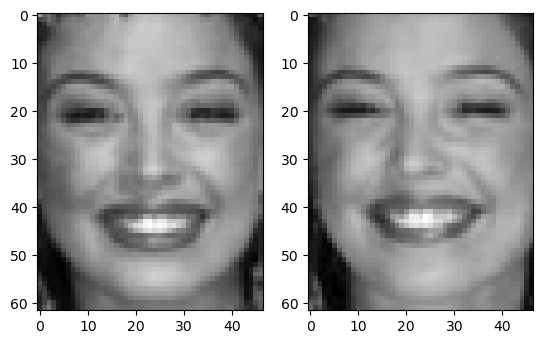

In [12]:
import matplotlib.pyplot as plt

def display_image_pair(images, n):
    """Display the nth image pair"""
    plt.subplot(1, 2, 1)
    plt.imshow(images[n, 0], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(images[n, 1], cmap='gray')
    plt.show()
    
# show the 100th image pair
display_image_pair(data_train['images'], 100)

### 2.2 Loading the evaluation data

We will now load the data and reshape it in the same way that we reshape the training data.  Note that for the evaluation data there are 1000 pairs.

In [10]:
data_eval = joblib.load('eval1.joblib')
data_eval['images'] = data_eval['data'].reshape((1000, 2, 62, 47))

To check that this has worked we will use our previous display function to show the 100th image pair.

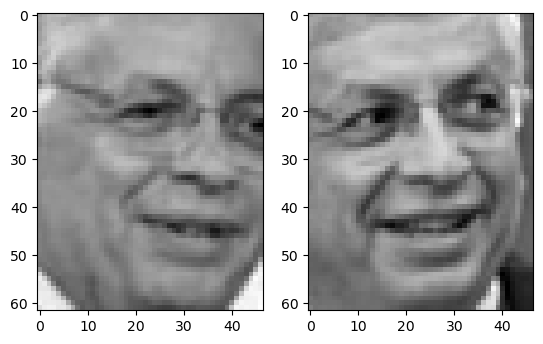

In [13]:
display_image_pair(data_eval['images'], 100)

Try calling the display function with different values for the index.

In [14]:
# SOLUTION

If your jupyter environment allows the use of widgets then the following code should allow you to browse through the training data image set.

In [41]:
# First we need to pip install the ipywidget package (-q supresses the pip output)
!pip -q install ipywidgets

In [42]:
from ipywidgets import interact, IntSlider, Dropdown

index_slider = IntSlider(value=0, min=0, max=2199, description="Image Pair Index")


def display_image_pair_wrapper(n):
    """Provides a 1-parameter interface for display_image_pair"""
    display_image_pair(data_train['images'], n)

In [43]:
interact(display_image_pair_wrapper, n=index_slider);


interactive(children=(IntSlider(value=0, description='Image Pair Index', max=2199), Output()), _dom_classes=('…

## 2.3 The baseline model

A baseline model has been trained for you and stored in the files `baseline_model.joblib`. This can be loaded using the `joblib` library. The code below loads model.


In [15]:
import joblib

model = joblib.load('baseline_model.joblib')

print(model)


Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=1))])


Note above that the print statement provides a description of the model. You can see that it is Pipeline with a single step, the KNN Classifier, constructed with $k=1$. The performance of this model is not great and it should be easy for you to improve on it.

We can check the performance by using the model's score method and passing the evaluation data as follows,

In [16]:
percent_correct = model.score(data_eval['data'], data_eval['target']) * 100 
print(f'The classifier is {percent_correct:.2f}% correct')

The classifier is 56.30% correct


You should get a score of 56.3%. This is significantly above chance (50%) but there is plenty of room for improvement.


## 3 Retraining your own KNN model

We should be able to replicate the baseline model score by training our own KNN.

### 3.1 Training a KNN

Below we make a classifier, train it and then evaluate it.


In [47]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a KNN classifier with k=1
knn = KNeighborsClassifier(n_neighbors=1)

# Train the model
knn.fit(data_train['data'], data_train['target'])

# Make predictions on the test set
y_pred = knn.score(data_eval['data'], data_eval['target']) * 100
print(y_pred)

56.3


### 3.2 Repeating using a pipeline

We will now repeat the process using a pipeline. The pipeline will have just the classifier and no preprocessing steps. This is not very useful but it illustrates the idea.

In [49]:
from sklearn.pipeline import Pipeline

# Create a pipeline with the KNN classifier
knn_pipeline = Pipeline([
    ('classifier', KNeighborsClassifier(n_neighbors=1))
])

# Train the pipeline
knn_pipeline.fit(data_train['data'], data_train['target'])

# Evaluate the pipeline
y_pred = knn_pipeline.score(data_eval['data'], data_eval['target']) * 100
print(y_pred)

56.3


we should get the same result.

But we can now add some preprocessing steps to the pipeline with very little modification to the code. For example, if we want to do standard scaler normalisation of the pixel features.

In [51]:
from sklearn.preprocessing import StandardScaler

# Create a pipeline with the KNN classifier
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Normalize the data
    ('classifier', KNeighborsClassifier(n_neighbors=1))  # Step 2: Perform the classification
])

# Train the pipeline
knn_pipeline.fit(data_train['data'], data_train['target'])

# Evaluate the pipeline
y_pred = knn_pipeline.score(data_eval['data'], data_eval['target']) * 100
print(y_pred)

56.89999999999999


### 3.3 Writing your own pipeline processing steps

What happens if you want to add your own data processing step to the pipe, i.e., a function that is not already defined in sklearn. 

For example, let us imaging that we write a function that downsamples the images by taking every nth pixel. We will write a function that takes the data as input, processes it and then returns the processed data.


In [53]:
def transform(data, factor):
    """ A crude downsampling of the images"""
    return data[:, ::factor])

This function is fine but to put it compatible with the sklearn pipeline framework, we need to make it part of a 'custom transformer' class. A transformer is a class that provides a 'transform' method that applies the transform. It can also have some parameters (which might be learnable), and a 'fit' method that is used to learn the parameters. 

The class has to inherit from a pair of sklearn classes: BaseEstimator and TransformerMixin. The code looks like this:

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyDownsample(BaseEstimator, TransformerMixin):
    def __init__(self, factor=2):
        self.factor = factor # The downsampling factor
        
    def fit(self, X, y=None):
        return self  # There is no fitting
    
    def transform(self, data, y=None):
        """Downsample the data"""
        return data[:,::self.factor]

We can now use this in our pipeline as follows

In [61]:
# Create a pipeline with the KNN classifier
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Normalize the data
    ('downsample', MyDownsample(factor=2)), # Step 2: Downsample by a factor of 2
    ('classifier', KNeighborsClassifier(n_neighbors=1))  # Step 3: Perform the classification
])

# Train the pipeline
knn_pipeline.fit(data_train['data'], data_train['target'])

# Evaluate the pipeline
y_pred = knn_pipeline.score(data_eval['data'], data_eval['target']) * 100
print(y_pred)

57.099999999999994


You can save this pipeline to a model file in the usual way. If someone want to load and use your model file then they will be able to do so as long as:

- Dependencies Are Installed: The person receiving the model must have the same Python environment with compatible versions of scikit-learn and any other libraries (e.g., numpy, joblib).

- Custom Transformers Are Available: If your pipeline includes a custom transformer like MyDownsample, they need access to its code to deserialize and use the model. This is because joblib serializes the references to the class, not the class definition itself.

This will be fine for the assignment because you have been asked to provide your `train.py` code. But you need to ensure that any custom transformer classes that you have written are included in the `train.py` file.



In cases like the above, where the transformer has no parameters that need to be fitted, you can simplify the code by using sklearn's 'FunctionTransformer' class, that will turn a simple function into a pipeline transformer for you. 

In this case you do not need to define a new class but can just define the function and use FunctionTransformer like this,

In [64]:
from sklearn.preprocessing import FunctionTransformer

# Below is the function that will be used in the pipeline...
def my_downsample(data, factor):
    return data[:, ::factor]

# ... and here is how it is added to the pipeline. Note how FunctionTransformer wraps around my_downsample
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Normalize the data
    ('downsample', FunctionTransformer(my_downsample, kw_args={'factor': 2})), # Step 2: Downsample
    ('classifier', KNeighborsClassifier(n_neighbors=1))  # Step 3: Perform the classification
])

# Train the pipeline in the usual way
knn_pipeline.fit(data_train['data'], data_train['target'])

# Evaluate the pipeline
y_pred = knn_pipeline.score(data_eval['data'], data_eval['target']) * 100
print(y_pred)

57.099999999999994


Again, trained pipelines using functions wrapped with FunctionTransformer like this can be save to joblib files and shared with others, as long as you also provide your code.

## 4. Evaluating using an ROC curve

In the following, I have provided an example of how to generate an ROC curve.

First, KNNs are not naturally probabilistic classifiers and so do not provide a very meaningful probability value when calling 'score_proba'. A value can be obtained when a large value of K is used but a large value of K gives poorer performance. So to make a better illustration I am swapping to using a LogisticRegression classifier.

The code below follows almost exactly the code in this weeks tutorial. 

In [106]:
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

# ... and here is how it is added to the pipeline. Note how FunctionTransformer wraps around my_downsample
lr_pipeline = Pipeline([
    ('downsample', FunctionTransformer(my_downsample, kw_args={'factor': 2})), # Step 2: Downsample
    ('classifier', LogisticRegression(C=0.01, solver='liblinear'))  # Step 3: Perform the classification
])

# Train the pipeline in the usual way
lr_pipeline.fit(data_train['data'], data_train['target'])

# Evaluate the pipeline
y_pred = lr_pipeline.score(data_eval['data'], data_eval['target']) * 100
print(y_pred)



52.2


We can now, i) use predict_proba to get scores; ii) calculate the FPR and TPR for different score thresholds and iii) compute the area under the curve (AUC). 

In [109]:
eval_scores = lr_pipeline.predict_proba(data_eval['data'])
eval_scores_positive_class = eval_scores[:,1]
fpr, tpr, _ = roc_curve(data_eval['target'], eval_scores_positive_class)
roc_auc = auc(fpr, tpr)

The code below then plots the ROC curve in a similar style to in the tutorial.

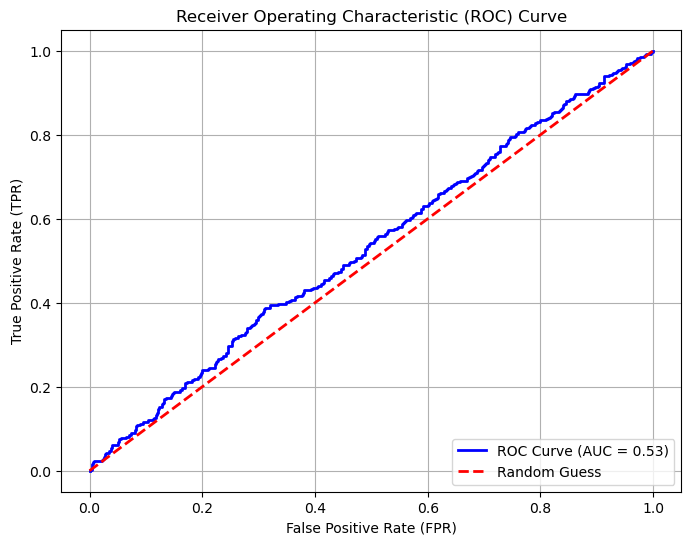

In [108]:

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

From the above we acan see that the AUC is very close to 0.5. The ROC curve lies very close to that which would be obtained if we were simply guessing. This is not surprising given that the accuracy (52.2%) was also close to chance performance. 

You may ask whether 52.2% is significantly better than chance in formal statistical sense. We can compute a z-score and a p-value using a Binomial test. The

In [117]:
import scipy.stats as stats

# Parameters
n = 1000  # Total trials
k = 522   # Correct guesses
p_null = 0.5  # Null hypothesis: chance level

# Observed proportion
p_observed = k / n

# Binomial test
binom_result = stats.binomtest(k, n, p_null, alternative='greater')
p_value_binomial = binom_result.pvalue
print(f"Binomial test p-value: {p_value_binomial:.4f}")


Binomial test p-value: 0.0869


This value is above than the standard 0.05\% threshold conventionally used for statistical significance. i.e. if we were simply guessing, we would get a result as least as good as this 8.69% of the time. We would not be allowed to call this result significant. Note that this does not mean that our classifier is not doing better than guessing, just that we have not got any evidence that it is. 

## 5. Runnning Python script from the command line

As an exercise, extract the code from this notebook into a .py file.  You can use the template below to help you get started.

In [ ]:
"""Python script for evaluating a model"""
import joblib
# Add all the import statements that you need.

# Add all the function definitions that you need

def main():
    """Function to evaluate a model."""

    # This is the first function that gets called. Start adding code here.


if __name__ == "__main__":
    main()


*Copyright &copy; 2024 Jon Barker, University of Sheffield. All rights reserved*.